In [ ]:
# https://maxhalford.github.io/blog/bayesian-linear-regression/

There are two types of machine learning methods - online and traditional machine learning.
Online model is dynamic and learnis on the fly.
Building blocks of the bayesian machine learning are as follows - 
- Predictive Distribution $p(y_i|x_i)$ - distribution we want to obtain
- Likelihood $p(y_i|x_i, \theta_i)$ - given the model parameters, how realistic is it to get the pair $(x_i, y_i)$
- Prior Distribution $p(\theta_i)$

Choosing a *good* prior is important. If not chosen properly we not get a tractable equation to update our model prameters and we'll need to depend upon techniques like **MCMC** and **variational inference**
- Posterior Distribution $p(\theta_{i+1}|\theta{i}, x_i, y_i) \propto p(y_i|x_i,\theta_i)p(\theta_i)$

Now the predictive distribution can be computed as  - 
$$
\int p(y_i|\boldsymbol{w}, x_i)p(\boldsymbol{w})d\boldsymbol{w}
$$
We have marginalized over the model parameters. This equation is intractible if we have not chosen the conjugate prior to the likelihood.

We’re computing a weighted average of the potential $y_i$ values for each possible model parameter $\boldsymbol{w}$

### Online Belief Updating 

Whenever a new pair of $(x_i, y_i)$ arrives we update the distribution of parameters - 
$$
p(\theta_{i+1}|\theta_{i}, x_i, y_i) \propto p(x_i, y_i|\theta_i)p(\theta_i)
$$

Before any data comes in and we are asked to predict the $y_0$ - 
$$
p(y_0|x_0) \propto p(y_0|x_0, \theta_0)p(\theta_0)
$$

Ones we see the first output $y_0$ and hence the pair $(x_0, y_0)$, we can update our model parameters - 
$$
p(\theta_1|\theta_0, x_0, y_0) \propto p(x_0, y_0|\theta_0)p(\theta_0)
$$

Now again the predictive distribution for the output $y_1$ is given by -
$$
p(y_1|x_1) \propto p(y_1|x_1, \theta_1)p(\theta_1|\theta_0, x_0, y_0)
$$

i.e. the prior of the weights of the current iteration is the posterior of the weights of the previous iteration.

Once we see the second output $y_1$, we can now update our prior again - 
$$
\begin{equation}
\begin{split}
p(\theta_2|\theta_1, x_1, y_1) & \propto p(y_1|x_1, \theta_1)p(\theta_1) \\
& \propto p(y_1|x_1, \theta_1)p(y_0|x_0, \theta_0)p(\theta_0)
\end{split}
\end{equation}
$$ 

similarly - 
$$
\begin{equation}
\begin{split}
p(\theta_3|\theta_2, x_1, y_1) &  \propto p(y_2|x_2, \theta_2)p(\theta_2) \\
& \propto p(y_2|x_2, \theta_2)p(y_1|x_1, \theta_1)p(y_0|x_0, \theta_0)p(\theta_0)
\end{split}
\end{equation}
$$

And so on and so forth. The posterior distribution at step $i+1$ becomes the prior at step $i$. **We only need to store the current distribution of weights to make everything work.**




### Linear Regression (Bayesian)

$$
y_i = w_i^Tx_i + \epsilon_i
$$

$y_i \in \boldsymbol{R}$,
$x_i \in \boldsymbol{R}^d$,
$w_i \in \boldsymbol{R}^d$

$\epsilon_i$ follows Gaussian Distribution. Hence the likelihood function is a gaussian distribution - 
$$
y_i|(x_i, w_i) \sim \mathcal{N}(w_i^Tx_i, \beta_i^{-1})
$$
$\beta_i$ - precision >0 

Prior distribution for the above likelihood function is the **multivariate gaussian distribtuion**
$$
w_0 \sim \mathcal{N}(m_0, S_0)
$$
$m_0$ is the mean of the distribution $\in \boldsymbol{R}^d$ <br>
$S_0$ is the covariance matrix $\in \boldsymbol{R}^{d*d}$

$$
\begin{align*}

m_0 & = (0, 0, ..., 0) \\
S_0 & = diag(\alpha^{-1}, \alpha^{-1}, ..., \alpha^{-1})
\end{align*}
$$

Now the posterior distribution of the weights is given by - 
$$
\begin{align*}
p(w_{i+1}|w_i, x_i, y_i) & = \mathcal{N}(m_{i+1}, S_{i+1}) \\
S_{i+1} & = (S_{i+1} + \beta x_ix_t^T)^{-1} \\
m_{i+1} & = S_{i+1}(S_{i}^{-1}m_i + \beta x_i^Ty_i)
\end{align*}
$$

And the predictive distribution is given as follows - 

$$
\begin{align*}
p(y_i) & = \mathcal{N}(\mu_i, \sigma_i) \\
\mu_i & = w_i^Tx_i \\
\sigma_i & = \frac{1}{\beta} + x_i^TS_ix_i
\end{align*}
$$

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

class BayesLinReg:

    def __init__(self, n_features, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        self.n_features = n_features
        self.mean = np.zeros(n_features)
        self.cov_inv = (1 / alpha) * np.eye(n_features)

    def learn(self, x, y):
        # Update the covariance matrix
        cov_inv = self.cov_inv + self.beta * np.outer(x, x)
        # Update the mean vector
        cov = np.linalg.inv(cov_inv)
        mean = cov @ (self.cov_inv @ self.mean + self.beta * y * x)

        self.cov_inv = cov_inv
        self.mean = mean

        return self

    def predict(self, x):

        # Obtain the predictive mean (Bishop eq. 3.58)
        y_hat = x @ self.mean

        # obtain the predictive variance (Bishop eq. 3.59)
        w_cov = np.linalg.inv(self.cov_inv)
        y_var = 1 / self.beta + x @ w_cov @ x.T

        return stats.norm(y_hat, np.sqrt(y_var))

    @property
    def weights_dist(self):
        cov = np.linalg.inv(self.cov_inv)
        return stats.multivariate_normal(self.mean, cov)

In [52]:
from sklearn import datasets
from sklearn import metrics

X, y = datasets.load_diabetes(return_X_y=True)

In [28]:
print(f'{y.shape = }\n{X.shape = }')

y.shape = (442,)
X.shape = (442, 10)


In [47]:
model = BayesLinReg(n_features=X.shape[1], alpha=1, beta=10)

In [48]:
y_pred = np.empty(len(y))

In [49]:
for i, (xi, yi) in enumerate(zip(X, y)):
    y_pred[i] = model.predict(xi).mean()
    model.learn(xi, yi)

print(metrics.mean_absolute_error(y, y_pred))

152.1680815439039


In [50]:
from sklearn import exceptions
from sklearn import linear_model
from sklearn import preprocessing

model = linear_model.SGDRegressor(eta0=.15)  # here eta0 is the learning rate

y_pred = np.empty(len(y))

for i, (xi, yi) in enumerate(zip(preprocessing.scale(X), y)):
    try:
        y_pred[i] = model.predict([xi])[0]
    except exceptions.NotFittedError:
        y_pred[i] = 0.
    model.partial_fit([xi], [yi])

print(metrics.mean_absolute_error(y, y_pred))

52.61549523108158


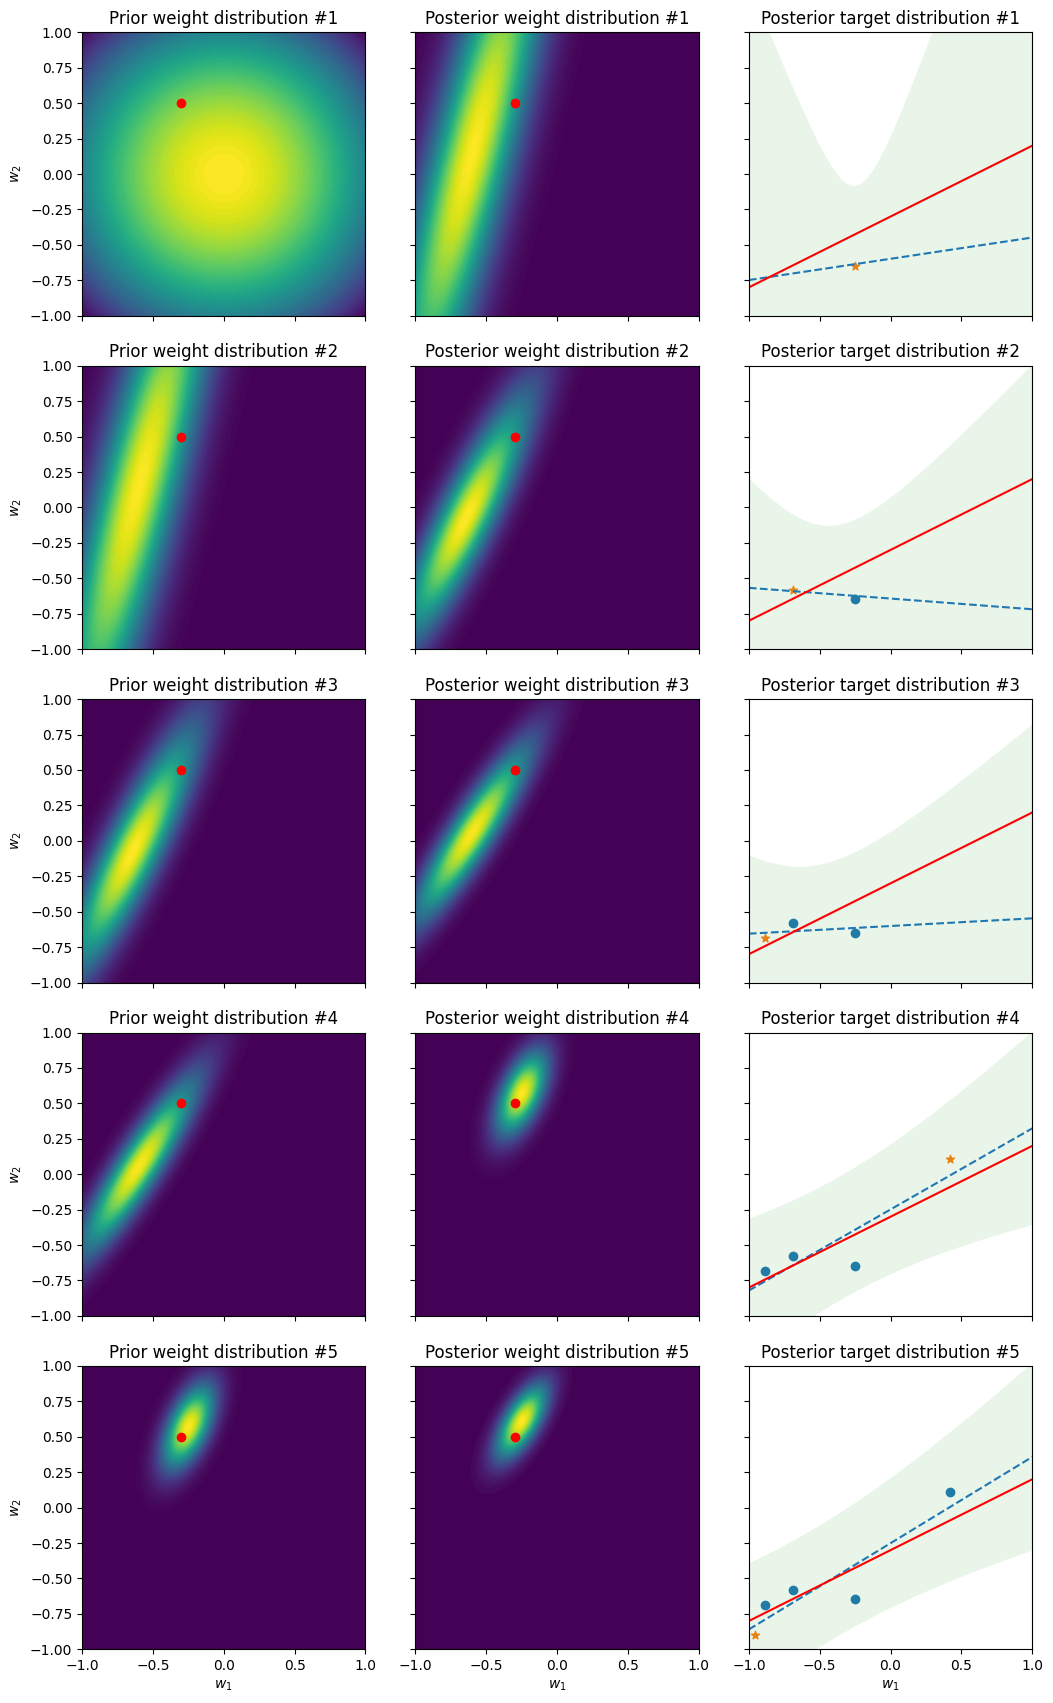

In [54]:
from mpl_toolkits.axes_grid1 import ImageGrid

np.random.seed(42)

# Pick some true parameters that the model has to find
weights = np.array([-.3, .5])

def sample(n):
    for _ in range(n):
        x = np.array([1, np.random.uniform(-1, 1)])
        y = np.dot(weights, x) + np.random.normal(0, .2)
        yield x, y

model = BayesLinReg(n_features=2, alpha=2, beta=25)

# The following 3 variables are just here for plotting purposes
N = 100
w = np.linspace(-1, 1, 100)
W = np.dstack(np.meshgrid(w, w))

n_samples = 5
fig = plt.figure(figsize=(7 * n_samples, 21))
grid = ImageGrid(
    fig, 111,  # similar to subplot(111)
    nrows_ncols=(n_samples, 3),  # creates a n_samplesx3 grid of axes
    axes_pad=.5  # pad between axes in inch.
)

# We'll store the features and targets for plotting purposes
xs = []
ys = []

def prettify_ax(ax):
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xlabel('$w_1$')
    ax.set_ylabel('$w_2$')
    return ax

for i, (xi, yi) in enumerate(sample(n_samples)):

    pred_dist = model.predict(xi)

    # Prior weight distribution
    ax = prettify_ax(grid[3 * i])
    ax.set_title(f'Prior weight distribution #{i + 1}')
    ax.contourf(w, w, model.weights_dist.pdf(W), N, cmap='viridis')
    ax.scatter(*weights, color='red')  # true weights the model has to find

    # Update model
    model.learn(xi, yi)

    # Prior weight distribution
    ax = prettify_ax(grid[3 * i + 1])
    ax.set_title(f'Posterior weight distribution #{i + 1}')
    ax.contourf(w, w, model.weights_dist.pdf(W), N, cmap='viridis')
    ax.scatter(*weights, color='red')  # true weights the model has to find

    # Posterior target distribution
    xs.append(xi)
    ys.append(yi)
    posteriors = [model.predict(np.array([1, wi])) for wi in w]
    ax = prettify_ax(grid[3 * i + 2])
    ax.set_title(f'Posterior target distribution #{i + 1}')
    # Plot the old points and the new points
    ax.scatter([xi[1] for xi in xs[:-1]], ys[:-1])
    ax.scatter(xs[-1][1], ys[-1], marker='*')
    # Plot the predictive mean along with the predictive interval
    ax.plot(w, [p.mean() for p in posteriors], linestyle='--')
    cis = [p.interval(.95) for p in posteriors]
    ax.fill_between(
        x=w,
        y1=[ci[0] for ci in cis],
        y2=[ci[1] for ci in cis],
        alpha=.1
    )
    # Plot the true target distribution
    ax.plot(w, [np.dot(weights, [1, xi]) for xi in w], color='red')

### Prediction Interval

In [55]:
# Getting the prediction inverval for the Bayesian Linear Regression model using normal distribution as input
np.random.seed(42)

model = BayesLinReg(n_features=2, alpha=1, beta=25)
pct_in_ci = 0
pct_in_ci_hist = []
n = 5_000

In [56]:
for i, (xi, yi) in enumerate(sample(n)):

    ci = model.predict(xi).interval(.95)
    in_ci = ci[0] < yi < ci[1]
    pct_in_ci += (in_ci - pct_in_ci) / (i + 1)  # online update of an average
    pct_in_ci_hist.append(pct_in_ci)

    model.learn(xi, yi)

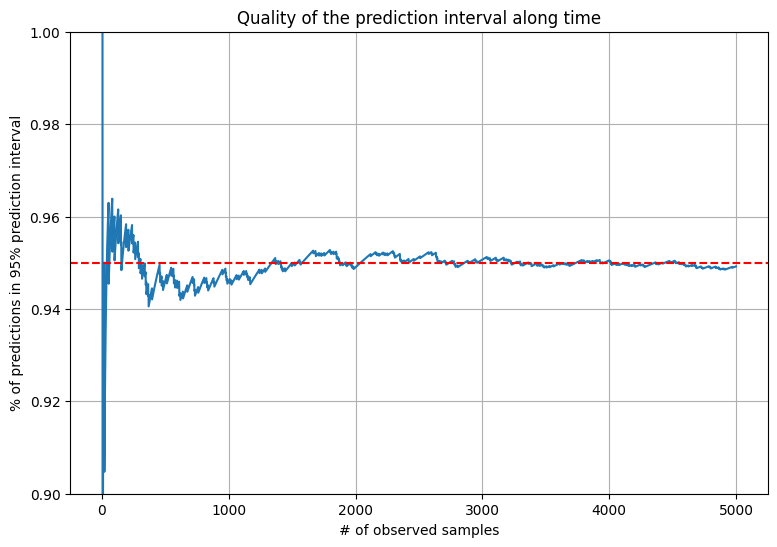

In [57]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(range(n), pct_in_ci_hist)
ax.axhline(y=.95, color='red', linestyle='--')
ax.set_title('Quality of the prediction interval along time')
ax.set_xlabel('# of observed samples')
ax.set_ylabel('% of predictions in 95% prediction interval')
ax.set_ylim(.9, 1)
ax.grid()

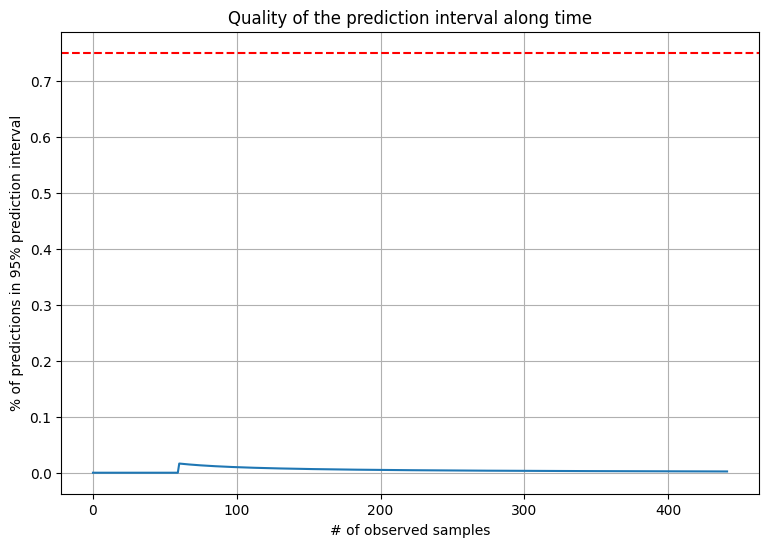

In [62]:
X, y = datasets.load_diabetes(return_X_y=True)

model = BayesLinReg(n_features=X.shape[1], alpha=1, beta=10)
pct_in_ci = 0
pct_in_ci_hist = []

for i, (xi, yi) in enumerate(zip(X, y)):

    ci = model.predict(xi).interval(.95)
    in_ci = ci[0] < yi < ci[1]
    pct_in_ci += (in_ci - pct_in_ci) / (i + 1)  # online update of an average
    pct_in_ci_hist.append(pct_in_ci)

    model.learn(xi, yi)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(range(len(X)), pct_in_ci_hist)
ax.axhline(y=.75, color='red', linestyle='--')
ax.set_title('Quality of the prediction interval along time')
ax.set_xlabel('# of observed samples')
ax.set_ylabel('% of predictions in 95% prediction interval')
ax.grid()